# Методы машинного обучения – Контрольная работа №8

# Трансформеры 🚀

#### Модель GPT

Компания OpenAI представила модель GPT в июне 2018 года в статье “Improving Language Understanding by Generative Pre-Training” («Улучшение понимания языка посредством генеративного предварительного обучения») почти ровно через год после появления оригинальной статьи о Transformer.

В этой статье авторы показывают, как архитектуру Transformer можно обучить на огромном объеме текстовых данных, чтобы предсказывать следующее слово в последовательности, а затем затем точно настроить для конкретных последующих задач.

Процесс предварительного обучения модели GPT включает обучение модели на большом корпусе текста под названием BookCorpus (4,5 ГБ текста из 7000 неопубликованных книг разных жанров). Во время предварительного обучения модель обучается предсказывать следующее слово в последовательности с учетом предыдущих слов. Этот процесс известен как языковое моделирование и используется для обучения модели пониманию структуры и закономерностей естественного языка.

После предварительного обучения модель GPT можно точно настроить для конкретной задачи, предоставив ей меньший набор данных для конкретной задачи. Точная настройка включает в себя корректировку параметров модели для лучшего соответствия поставленной задаче. Например, модель можно точно настроить для таких задач, как классификация, оценка сходства или ответы на вопросы.

Архитектура GPT с тех пор была улучшена и расширена компанией OpenAI с выпуском последующих моделей, таких как GPT-2, GPT-3, GPT-3.5 и GPT-4. Эти модели обучаются на больших наборах данных и имеют большую емкость, поэтому могут генерировать более сложный и связный текст. Модели GPT получили широкое распространение среди исследователей и отраслевых практиков и способствовали значительному прогрессу в задачах обработки естественного языка.

Попробуем создать собственную версию исходной модели GPT, обученную на меньшем количестве данных, но по-прежнему использующую те же компоненты и основные принципы.

### Набор данных винных обзоров (Wine Reviews Dataset)

Мы будем использовать набор данных Wine Reviews, доступный через Kaggle (https://www.kaggle.com/datasets/zynicide/wine-reviews). Это набор из более чем 130 000 обзоров вин с сопутствующими метаданными, такими как описание и цена.

In [1]:
# требуется keras версии 3
!pip show keras

Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow


In [2]:
!pip install --upgrade tensorflow keras

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Keras v.3 !

In [4]:
%load_ext autoreload
%autoreload 2
import keras
from keras import layers, models, losses, callbacks
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf

## Параметры

In [5]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
BATCH_SIZE = 32
EPOCHS = 5

## Загрузка данных

Подготовка данных идентична подготовке данных для сети LSTM. Загружаем данные с Google диска (https://drive.google.com):

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load the full dataset
with open("/content/drive/MyDrive/winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)

In [8]:
wine_data[10]

{'points': '87',
 'title': 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
 'description': 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 19,
 'designation': 'Mountain Cuvée',
 'variety': 'Cabernet Sauvignon',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'province': 'California',
 'country': 'US',
 'winery': 'Kirkland Signature'}

Создаем список текстовых описаний для каждого вина:

In [9]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [10]:
# Count the reviews
n_wines = len(filtered_data)
print(f"{n_wines} reviews loaded")

129907 reviews loaded


In [11]:
example = filtered_data[25]
print(example)

wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.


## Токенизируем данные

Дополним пунктуацию пробелами, чтобы каждый знак препинания воспринимался как отдельное слово.

In [12]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [13]:
# Display an example of a review
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

Конвертируем список в датасет Tensorflow и пропустим текст через слой `TextVectorization`, который маркирует данные и дополняет/обрезает каждую строку до фиксированной длины.

In [14]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [15]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [16]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [17]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [18]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


## Создание обучающего набора данных

Создадим обучающий набор данных, в котором входными данными являются векторы с токенами текста, а прогнозируемыми выходными данными являются те же векторы, смещенные на один токен влево и дополненные справа нулевым значением.

In [19]:
# Create the training set of recipes and the same text
# shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

In [20]:
example_input_output = train_ds.take(1).get_single_element()

In [21]:
# Example Input
example_input_output[0][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,   20,    2,   29,    2,   65,   14,   63,   24,
         27,    2,  622, 8711,    1,   13,    8,    1,    1,    3,    5,
         12,    7,   13,  128,   19, 5532,  267,    1,    9,    1,    1,
          4,   68,    3,  246,    5,  593,   23,    6,   28,    3,   15,
         18,   21,  128,   32,    8, 1878,    9,  100,    3,   11, 1871,
       3384,    9,   45,   44,    3,   45,  200,    5,  374,  394,    4,
        293,    3,  132,    5,    8,  358,    9,   86, 4647,  116,   23,
          6,   28,    4])>

In [22]:
# Example Output (shifted by one token)
example_input_output[1][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,   20,    2,   29,    2,   65,   14,   63,   24,   27,
          2,  622, 8711,    1,   13,    8,    1,    1,    3,    5,   12,
          7,   13,  128,   19, 5532,  267,    1,    9,    1,    1,    4,
         68,    3,  246,    5,  593,   23,    6,   28,    3,   15,   18,
         21,  128,   32,    8, 1878,    9,  100,    3,   11, 1871, 3384,
          9,   45,   44,    3,   45,  200,    5,  374,  394,    4,  293,
          3,  132,    5,    8,  358,    9,   86, 4647,  116,   23,    6,
         28,    4,    0])>

### Причинное маскирование

Без маскирования модель GPT смогла бы идеально угадать следующее слово в предложении, поскольку в качестве функции она использовала бы ключ самого слова. Код для создания причинной маски и полученный массив маски показаны ниже:

In [23]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1),
         tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## Блок трансформера

__Блок трансформера__ — это отдельный компонент внутри трансформера, который применяет некоторые сквозные связи  (skip connections), полносвязные (плотные) слои и нормализацию слоя многомерного внимания.

Входные данные передаются через  слой многомерного внимания и добавляются к выходным данным — это сквозные связи (skip connections), часто встречающиеся в современных архитектурах глубокого обучения. Это означает, что можно построить очень глубокие нейронные сети, которые не так сильно страдают от проблемы исчезающего градиента, поскольку сквозные связи обеспечивают магистраль (highway) без градиента, что позволяет нейронной сети беспрепятственно передавать информацию вперед неискаженной.

В блоке трансформера используются слои нормализации  (`keras.layers.LayerNormalization`), чтобы обеспечить стабильность процесса обучения. Слой нормализации выполняет стандартизацию каждого экземпляра входных данных так, что его матожидание становится равным нулю, а дисперсия равной единице. Статистика нормализации рассчитывается для каждого экземпляра входных данных по всем каналам (признакам).

В глубоком обучении также применяются слои пакетной нормализации (`keras.layers.BatchNormalization`), где выходные данные каждого канала (нейрона) стандартизуются так, чтобы среднее значение по пакету было равно нулю, а дисперсия равна единице. Статистика нормализации рассчитывается для каждого канала (признака) по всему пакету входных данных.



In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim,
                 dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

### Позиционное кодирование

На уровне многомерного внимания нет ничего, что заботилось бы о порядке ключей. Скалярное произведение между каждым ключом и запросом вычисляется параллельно, а не последовательно, как в рекуррентной нейронной сети. Это сильная сторона (из-за повышения эффективности распараллеливания), но также и проблема, поскольку нам нужно, чтобы слой внимания имел возможность прогнозировать разные выходные данные для следующих двух предложений:
* The dog looked at the boy and ... (barked?)
* The boy looked at the dog and ... (smiled?)

Чтобы решить эту проблему, при создании входных данных для блока трансформера используется метод, называемый __позиционным кодированием__. Вместо того, чтобы кодировать каждый токен только с помощью эмбединга токена, мы также кодируем позицию токена, используя эмбединг позиции.

Эмбединг токена создается с использованием стандартного слоя эмбединга для преобразования каждого токена в вектор. Можно создать позиционный эмбединг таким же образом, используя стандартный слой эмбединга для преобразования каждой целочисленной позиции в вектор.


In [25]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

## Построение модели трансформера

Чтобы собрать все в модель, нам нужно передать входной текст через слой эмбединга токена и позиции, а затем через блок трансформера. Конечным результатом работы сети является простой плотный слой с активацией `softmax` по количеству слов в словаре.

In [26]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(
    MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM
)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

In [27]:
gpt.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 256)           │       2,580,480 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ [(None, None, 256), (None,  │         658,688 │
│                                      │ 2, None, None)]             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10000)         │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,809,168 (22.16 MB)

 Trainable params: 5,809,168 (22.16 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение трансформера

In [28]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1],
                                                   temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + \
                           self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [29]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/gpt.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="/content/drive/MyDrive/logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [30]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback,
               tensorboard_callback,
               text_generator],
)

Epoch 1/5
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.5966
generated text:
wine review : france : loire valley : merlot : this firmly structured and tannic , dense wine is the hallmark of ripe black fruits to balance out of white fruits . the wood aging has plenty of wood lifted the fruit and great fruit . it ' s going to age over the next few years . drink from 2019 . 

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 538s 124ms/step - loss: 2.5965
Epoch 2/5
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9748
generated text:
wine review : italy : piedmont : nebbiolo : aromas of tilled earth , new leather and tobacco lead the nose . the powerful palate offers black cherry , blackberry and cinnamon while baking spice notes add depth to the juicy palate , framed by youthfully assertive tannins that lend balancing acidity . drink 2023–2033 . 

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 86s 21ms/step - loss: 1.9748
Epoch 3/5
4059/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9007
generated text:
win

In [31]:
# Save the final model
gpt.save("/content/drive/MyDrive/gpt.keras")

In [32]:
# Load the model
# gpt = models.load_model("/content/drive/MyDrive/gpt.keras", compile=True)

# Генерация текста при помощи трансформера

Будем использовать тот же класс `TextGenerator`, который использовался для генерации текста сетью LSTM, включая параметр температуры, который определяет, насколько детерминированным должен быть процесс выборки.


In [33]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [34]:
info = text_generator.generate(
    "wine review : us", max_tokens=80, temperature=1.0
)


generated text:
wine review : us : california : grenache : crisp and sharp aromas of ripe strawberries greet the nose followed by the palate of this medium - bodied , california grenache - made red . bright cherry flavors faintly up by the barrel heat of the finish . 



In [35]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : tuscany : red blend : this is a blend of sangiovese ( 70 % cabernet sauvignon and 30 % merlot with 10 % cabernet franc and 10 % cabernet sauvignon . the palate offers black cherry , coffee and black pepper alongside astringent tannins that give it a few years to soften . drink soon . 



#### Просмотр оценок внимания

Мы также можем попросить модель сообщить нам, сколько внимания уделяется каждому слову при выборе следующего слова в предложении. Блок трансформера выводит веса внимания для каждого блока внимания, которые представляют собой распределение `softmax` по предыдущим словам в предложении.

Чтобы продемонстрировать это, на рис. ниже показаны пять главных токенов с наибольшей вероятностью трех разных входных подсказок, а также среднее внимание обеих блоков внимания по отношению к каждому предыдущему слову. Предыдущие слова окрашены в соответствии с их показателем внимания, усредненным по двум блокам внимания. Более темный синий означает, что слову уделяется больше внимания.

In [36]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : rheingau : riesling : whiffs of crushed stones and crushed stone lend a savory tone to this dry , light - bodied spätlese . it ' s expansive on the palate , with a crush of mineral and lemon rind on the finish . 



::   	100.0%
-:   	0.0%
blend:   	0.0%
grosso:   	0.0%
blanc:   	0.0%
--------



mosel:   	93.25%
rheingau:   	5.73%
pfalz:   	0.57%
rheinhessen:   	0.23%
franken:   	0.09%
--------



::   	100.0%
-:   	0.0%
blanc:   	0.0%
,:   	0.0%
grosso:   	0.0%
--------



riesling:   	99.97%
spätburgunder:   	0.02%
pinot:   	0.0%
gewürztraminer:   	0.0%
white:   	0.0%
--------



::   	100.0%
blanc:   	0.0%
-:   	0.0%
grosso:   	0.0%
blend:   	0.0%
--------



while:   	38.19%
whiffs:   	19.76%
a:   	13.49%
this:   	6.37%
hints:   	3.29%
--------



of:   	100.0%
suggesting:   	0.0%
are:   	0.0%
recall:   	0.0%
include:   	0.0%
--------



smoke:   	85.35%
saffron:   	3.88%
crushed:   	1.91%
struck:   	1.32%
honey:   	0.92%
--------



stones:   	45.65%
slate:   	27.99%
stone:   	21.93%
minerals:   	3.03%
mineral:   	0.78%
--------



and:   	55.43%
lend:   	35.33%
,:   	7.97%
are:   	0.87%
lends:   	0.15%
--------



crushed:   	33.78%
lime:   	13.61%
stone:   	12.72%
smoke:   	7.79%
river:   	7.34%
--------



stone:   	63.9%
slate:   	15.37%
stones:   	11.91%
minerals:   	7.53%
granite:   	0.45%
--------



add:   	43.71%
lend:   	32.68%
are:   	17.14%
accent:   	2.48%
notes:   	0.63%
--------



a:   	74.6%
complexity:   	6.62%
savoriness:   	4.62%
savory:   	4.54%
an:   	3.99%
--------



savory:   	69.18%
lavish:   	5.72%
mysteriously:   	2.97%
floral:   	2.71%
hint:   	2.59%
--------



tone:   	99.59%
,:   	0.23%
sheen:   	0.06%
edge:   	0.03%
feel:   	0.01%
--------



to:   	100.0%
of:   	0.0%
for:   	0.0%
on:   	0.0%
and:   	0.0%
--------



this:   	99.81%
nose:   	0.04%
fresh:   	0.04%
the:   	0.03%
ripe:   	0.02%
--------



dry:   	91.19%
off:   	4.13%
semi:   	1.16%
gorgeously:   	0.32%
silken:   	0.3%
--------



,:   	99.26%
semi:   	0.2%
but:   	0.19%
dry:   	0.13%
off:   	0.06%
--------



medium:   	74.23%
full:   	12.74%
richly:   	1.41%
lusciously:   	1.36%
off:   	1.31%
--------



-:   	99.88%
,:   	0.04%
bodied:   	0.02%
spätlese:   	0.01%
and:   	0.01%
--------



bodied:   	80.97%
footed:   	19.02%
to:   	0.01%
medium:   	0.0%
framed:   	0.0%
--------



riesling:   	56.56%
spätlese:   	22.93%
wine:   	10.55%
kabinett:   	4.42%
dry:   	2.79%
--------



.:   	99.99%
that:   	0.0%
,:   	0.0%
of:   	0.0%
full:   	0.0%
--------



it:   	92.86%
the:   	5.1%
on:   	0.62%
juicy:   	0.28%
crisp:   	0.22%
--------



':   	99.96%
has:   	0.02%
offers:   	0.01%
balances:   	0.0%
is:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
[UNK]:   	0.0%
balances:   	0.0%
shows:   	0.0%
--------



lusciously:   	35.06%
juicy:   	25.39%
a:   	10.72%
crisp:   	3.04%
medium:   	2.23%
--------



on:   	99.21%
in:   	0.4%
and:   	0.31%
,:   	0.07%
with:   	0.01%
--------



the:   	99.96%
first:   	0.03%
its:   	0.01%
entry:   	0.0%
a:   	0.0%
--------



palate:   	99.99%
midpalate:   	0.01%
tongue:   	0.0%
sip:   	0.0%
finish:   	0.0%
--------



,:   	98.37%
with:   	1.2%
but:   	0.22%
and:   	0.2%
yet:   	0.01%
--------



with:   	73.93%
but:   	24.78%
yet:   	0.36%
it:   	0.27%
and:   	0.17%
--------



a:   	42.24%
hints:   	11.54%
notes:   	7.88%
flavors:   	7.15%
juicy:   	6.55%
--------



spray:   	13.39%
reverberating:   	12.66%
hint:   	10.63%
delicate:   	7.35%
lingering:   	5.76%
--------



of:   	100.0%
facility:   	0.0%
,:   	0.0%
that:   	0.0%
like:   	0.0%
--------



mineral:   	31.68%
lemon:   	27.27%
lime:   	14.64%
minerals:   	6.77%
tangerine:   	4.64%
--------



,:   	54.3%
and:   	19.43%
tones:   	15.33%
sheen:   	4.32%
-:   	2.21%
--------



lime:   	18.57%
stone:   	14.87%
crushed:   	13.09%
steel:   	12.16%
slate:   	6.35%
--------



rind:   	34.13%
-:   	32.56%
flavors:   	13.7%
and:   	7.39%
peel:   	2.9%
--------



flavors:   	29.66%
and:   	25.28%
,:   	15.93%
on:   	6.31%
that:   	5.84%
--------



the:   	99.53%
a:   	0.45%
this:   	0.02%
its:   	0.0%
an:   	0.0%
--------



finish:   	98.56%
midpalate:   	0.9%
palate:   	0.39%
long:   	0.07%
nose:   	0.05%
--------



.:   	95.95%
,:   	4.02%
that:   	0.03%
and:   	0.0%
with:   	0.0%
--------



:   	59.55%
it:   	35.52%
drink:   	4.17%
the:   	0.32%
enjoy:   	0.3%
--------



## Классификация изображений при помощи трансформера для изображений

В этом коде реализована модель Vision Transformer (ViT) для классификации изображений, и она демонстрируется на наборе данных CIFAR-10. Модель ViT применяет архитектуру Transformer с самовниманием к последовательностям фрагментов изображения без использования слоев свертки.

### Подготовка данных

In [37]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


### Конфигурация гиперпараметров

In [38]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

Используем аугментацию данных:

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Реализация многослойного перцептрона (MLP):

In [40]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Создание патчей изображения в слое:

In [41]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Визуализируем патчи для изображения:

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


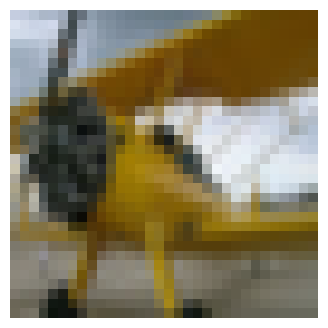

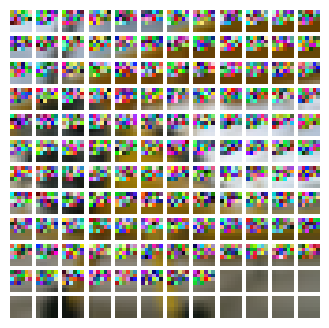

In [42]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

### Реализация слоя кодирования патчей

Слой `PatchEncoder` будет линейно преобразовывать патч, проецируя его в вектор размером `projection_dim`. Кроме того, он добавляет обучаемый позиционный эмбеддинг в проецируемый вектор.

In [43]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


### Построение модели ViT

Модель ViT состоит из нескольких блоков Transformer, которые используют слой `layer.MultiHeadAttention` в качестве механизма самовнимания, применяемого к последовательности патчей. Блоки Transformer создают тензор формы $[batch_size, num_patches, projection_dim]$, который обрабатывается с помощью `softmax` для получения  вероятностей классов.
В отличие от описанной в статье методики, которая добавляет обучаемое встраивание к последовательности закодированных патчей для использования в качестве представления изображения, все выходные данные окончательного блока Transformer преобразуются с помощью layer.Flatten() и используются в качестве входных данных представления изображения для головки классификатора. Обратите внимание, что слой layer.GlobalAveragePooling1D также может использоваться вместо этого для агрегирования выходных данных блока Transformer, особенно когда количество патчей и размеры проекции велики.

In [44]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


### Создание, обучение и оценка модели

In [45]:
ViT = create_vit_classifier()


In [46]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

ViT.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [47]:
checkpoint_filepath = "/content/drive/MyDrive/ViT_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [48]:
history = ViT.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 394ms/step - accuracy: 0.2449 - loss: 2.7585 - top-5-accuracy: 0.7335 - val_accuracy: 0.4356 - val_loss: 1.5462 - val_top-5-accuracy: 0.9118
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.4126 - loss: 1.6343 - top-5-accuracy: 0.8851 - val_accuracy: 0.5416 - val_loss: 1.2714 - val_top-5-accuracy: 0.9428
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.4883 - loss: 1.4277 - top-5-accuracy: 0.9200 - val_accuracy: 0.5780 - val_loss: 1.1981 - val_top-5-accuracy: 0.9564
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 421ms/step - accuracy: 0.5334 - loss: 1.3131 - top-5-accuracy: 0.9350 - val_accuracy: 0.6046 - val_loss: 1.1108 - val_top-5-accuracy: 0.9610
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.5596 - loss: 1.2449 - top-5-accuracy: 0.9422 - val_accuracy: 0.6244 - val_loss: 1.0679 - val_top-5-accuracy: 0.9648
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.5821 

In [49]:
ViT.load_weights(checkpoint_filepath)

In [50]:
# Save the final model
ViT.save("/content/drive/MyDrive/ViT.keras")
# ViT = models.load_model("/content/drive/MyDrive/ViT.keras", compile=True)

In [51]:
_, accuracy, top_5_accuracy = ViT.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6894 - loss: 0.8746 - top-5-accuracy: 0.9747
Test accuracy: 69.13%


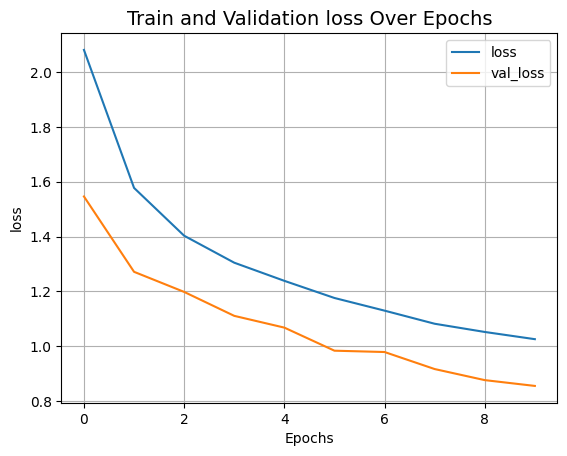

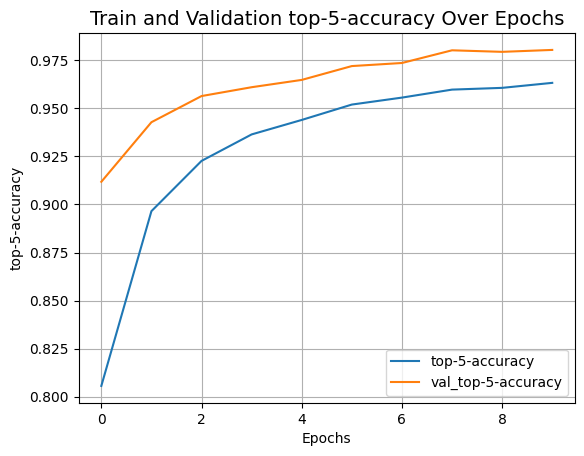

In [52]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

#### Задание (10 баллов)

Для закрепленного за Вами варианта работы:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.
2. Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте по одному изображению из каждого класса, подписывая изображение меткой класса.
3. Постройте нейронные сети различных архитектур (MLP, CNN, RNN, трансформер) для задачи многоклассовой классификации изображений (архитектуры и требования к сетям указаны в индивидуальном задании), используя функции потерь, указанные в индивидуальном задании. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Обучайте нейронные сети с использованием валидационной выборки, сформированной в п. 1. Останавливайте переобучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд.
4. Вычислите и выведите в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) для обучающей и тестовой выборок.
5. Визуализируйте кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).
6. Оцените качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите название нейронной сети с лучшим качеством.


